In [1]:
# IMAGE CLASSIFIER - USING TENSORFLOW

import PIL
import pathlib
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# for initial testing, using the greybox images
data_dir = pathlib.Path('../data/img/screenshots/grey_env/')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6000


In [4]:
# Set up 3 classes
dominus = list(data_dir.glob('dom/*'))
fennec = list(data_dir.glob('fen/*'))
octane = list(data_dir.glob('oct/*'))

In [5]:
# define loader parameters
batch_size = 32
img_height = 180
img_width = 180

In [6]:
# 80% of images used for training, leaving 20% for validation
# Note: `.image_dataset_from_directory` resizes the images.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=327,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6000 files belonging to 3 classes.
Using 4800 files for training.


In [7]:
# create 20% validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=327,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6000 files belonging to 3 classes.
Using 1200 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['dom', 'fen', 'oct']


## VIZ

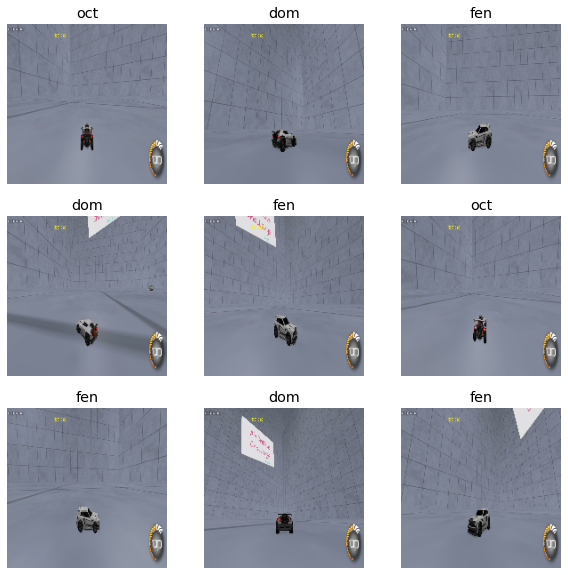

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
# TODO: use skimage.io to crop images (keep just car)
# TODO: use imageaug.io augment all images

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


### Data Performance Optimization  
from the [tensorflow data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching)  

[Dataset.cache()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

[Dataset.prefetch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) overlaps data preprocessing and model execution while training. 

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## It's Modeling Time!  

In [13]:
# TODO: List specs of model in cell above ^^^^^
#     ~~ Starting with ~~
# Convolution Blocks: 3
# Fully Connected Layer: 128 units
# Activation: Relu

# Not tuned for high accuracy, this is just the beginning

In [14]:
# Classes: Dominus, Fennec, Octane
num_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [15]:
# TODO: Why adam?
# TODO: Why SCC loss function?
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
# View all layers of network
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

## Time to train!

In [17]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
150/150 [==============================] - 12s 77ms/step - loss: 0.5615 - accuracy: 0.7465 - val_loss: 0.1361 - val_accuracy: 0.9642
Epoch 2/10
150/150 [==============================] - 3s 19ms/step - loss: 0.0992 - accuracy: 0.9679 - val_loss: 0.0401 - val_accuracy: 0.9917
Epoch 3/10
150/150 [==============================] - 3s 19ms/step - loss: 0.0383 - accuracy: 0.9873 - val_loss: 0.0190 - val_accuracy: 0.9958
Epoch 4/10
150/150 [==============================] - 3s 19ms/step - loss: 0.0285 - accuracy: 0.9927 - val_loss: 0.0148 - val_accuracy: 0.9942
Epoch 5/10
150/150 [==============================] - 3s 19ms/step - loss: 0.0087 - accuracy: 0.9975 - val_loss: 0.0125 - val_accuracy: 0.9967
Epoch 6/10
150/150 [==============================] - 3s 19ms/step - loss: 0.0088 - accuracy: 0.9979 - val_loss: 0.0083 - val_accuracy: 0.9975
Epoch 7/10
150/150 [==============================] - 3s 19ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0105 - val_accuracy: 0.998

## Visualize Results

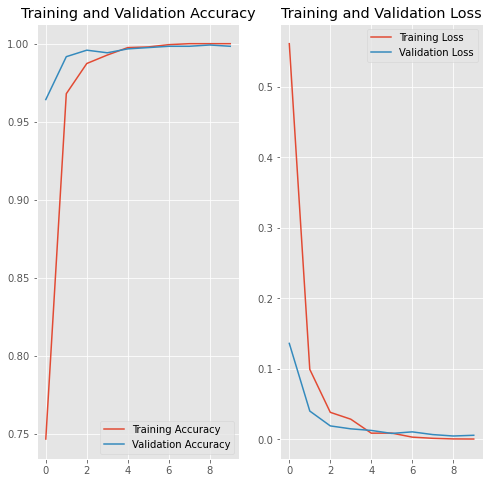

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Predict on **new** data